![logo](Data/logo.png)

This notebook shows how to load data from a netcdf using `xarray` file and plot them in a coordinate system using cartopy.

In [1]:
#import library
import xarray as xr
import netCDF4
import cartopy
import cftime
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pyproj

We use here a netcdf file that include output from a MesoNH simulation.

In [2]:
fileinput = '/data/IMFSE/PythonCourse/MNH/FCAST_model1.nc'

to open the netcdf file for this file, we need to set `decode_times` to False, as the time units in the file was not set properly.

In [3]:
ds = xr.open_dataset(fileinput, decode_times=False)

you can see the time unit using netCDF4 which is a less lower level library that deals directly with netCDF file structures. It requires more manual handling of the data, such as keeping track of dimensions and coordinates separately. 

In [4]:
nc = netCDF4.Dataset(fileinput)
nc['time']

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    long_name: time
    standard_name: time
    units: seconds since fire ignition: 2022-07-16 00:00:00.000000
unlimited dimensions: time
current shape = (49,)
filling on, default _FillValue of 9.969209968386869e+36 used

units should read `seconds since: 2022-07-16 00:00:00.000000` to be correctly interpreted in `xarray`  
To correct this we run the following commands:

In [5]:
# Extract the time variable
time_var = ds["time"]

# Get the time units, and remove the non-standard prefix
units = time_var.attrs['units'].replace('fire ignition: ', '')

# Convert the time variable using cftime
times = cftime.num2date(time_var.values, units=units, calendar='standard')

# Convert to pandas datetime if needed
times_as_datetime = [datetime(year=t.year, month=t.month, day=t.day, 
                              hour=t.hour, minute=t.minute, second=t.second,microsecond=t.microsecond)
                     for t in times]


# Replace the time variable in the dataset with the converted times
ds["time"] = ("time", times_as_datetime)

# Print the dataset to check the time conversion
print(ds["time"])

<xarray.DataArray 'time' (time: 49)> Size: 392B
array(['2022-07-16T00:00:00.000000000', '2022-07-16T01:00:00.000000000',
       '2022-07-16T02:00:00.000000000', '2022-07-16T03:00:00.000000000',
       '2022-07-16T04:00:00.000000000', '2022-07-16T05:00:00.000000000',
       '2022-07-16T06:00:00.000000000', '2022-07-16T07:00:00.000000000',
       '2022-07-16T08:00:00.000000000', '2022-07-16T09:00:00.000000000',
       '2022-07-16T10:00:00.000000000', '2022-07-16T11:00:00.000000000',
       '2022-07-16T12:00:00.000000000', '2022-07-16T13:00:00.000000000',
       '2022-07-16T14:00:00.000000000', '2022-07-16T15:00:00.000000000',
       '2022-07-16T16:00:00.000000000', '2022-07-16T17:00:00.000000000',
       '2022-07-16T18:00:00.000000000', '2022-07-16T19:00:00.000000000',
       '2022-07-16T20:00:00.000000000', '2022-07-16T21:00:00.000000000',
       '2022-07-16T22:00:00.000000000', '2022-07-16T23:00:00.000000000',
       '2022-07-17T00:00:00.000000000', '2022-07-17T01:00:00.000000000',
   

the dataset is now well define. below is an overview of the data

In [23]:
ds['lat'][:,0]

<xarray.DataArray 'lat' (y: 100)> Size: 800B
array([41.012622, 41.030853, 41.049079, 41.0673  , 41.085515, 41.103726,
       41.121932, 41.140133, 41.158329, 41.176519, 41.194705, 41.212885,
       41.231061, 41.249231, 41.267397, 41.285557, 41.303712, 41.321863,
       41.340008, 41.358148, 41.376283, 41.394413, 41.412538, 41.430658,
       41.448773, 41.466882, 41.484987, 41.503087, 41.521181, 41.539271,
       41.557355, 41.575435, 41.593509, 41.611579, 41.629643, 41.647702,
       41.665756, 41.683805, 41.701849, 41.719888, 41.737922, 41.755951,
       41.773975, 41.791993, 41.810007, 41.828016, 41.846019, 41.864018,
       41.882011, 41.899999, 41.917983, 41.935961, 41.953934, 41.971902,
       41.989865, 42.007823, 42.025776, 42.043724, 42.061666, 42.079604,
       42.097536, 42.115464, 42.133386, 42.151304, 42.169216, 42.187123,
       42.205025, 42.222923, 42.240815, 42.258701, 42.276583, 42.29446 ,
       42.312332, 42.330199, 42.34806 , 42.365917, 42.383768, 42.401614,
       42.419456, 42.437292, 42.455123, 42.472949, 42.49077 , 42.508586,
       42.526397, 42.544202, 42.562003, 42.579799, 42.597589, 42.615375,
       42.633155, 42.65093 , 42.668701, 42.686466, 42.704226, 42.721981,
       42.739731, 42.757475, 42.775215, 42.79295 ])
Coordinates:
    x        float32 4B 2e+03
  * y        (y) float32 400B 2e+03 4e+03 6e+03 ... 1.96e+05 1.98e+05 2e+05
Attributes:
    long_name:      latitude center cell
    standard_name:  lat
    units:          degree

In [25]:
ds['lon'][0,:]

<xarray.DataArray 'lon' (x: 100)> Size: 800B
array([1.215948, 1.240112, 1.264277, 1.288441, 1.312605, 1.33677 , 1.360934,
       1.385098, 1.409263, 1.433427, 1.457591, 1.481756, 1.50592 , 1.530084,
       1.554249, 1.578413, 1.602577, 1.626742, 1.650906, 1.67507 , 1.699235,
       1.723399, 1.747563, 1.771728, 1.795892, 1.820056, 1.844221, 1.868385,
       1.892549, 1.916714, 1.940878, 1.965042, 1.989206, 2.013371, 2.037535,
       2.061699, 2.085864, 2.110028, 2.134192, 2.158357, 2.182521, 2.206685,
       2.23085 , 2.255014, 2.279178, 2.303343, 2.327507, 2.351671, 2.375836,
       2.4     , 2.424164, 2.448329, 2.472493, 2.496657, 2.520822, 2.544986,
       2.56915 , 2.593315, 2.617479, 2.641643, 2.665808, 2.689972, 2.714136,
       2.738301, 2.762465, 2.786629, 2.810794, 2.834958, 2.859122, 2.883286,
       2.907451, 2.931615, 2.955779, 2.979944, 3.004108, 3.028272, 3.052437,
       3.076601, 3.100765, 3.12493 , 3.149094, 3.173258, 3.197423, 3.221587,
       3.245751, 3.269916, 3.29408 , 3.318244, 3.342409, 3.366573, 3.390737,
       3.414902, 3.439066, 3.46323 , 3.487395, 3.511559, 3.535723, 3.559888,
       3.584052, 3.608216])
Coordinates:
  * x        (x) float32 400B 2e+03 4e+03 6e+03 ... 1.96e+05 1.98e+05 2e+05
    y        float32 4B 2e+03
Attributes:
    long_name:      longitude center cell
    standard_name:  lon
    units:          degree

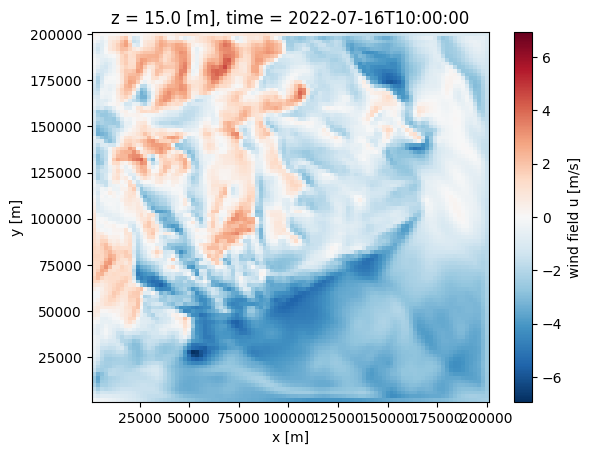

In [19]:
#now for example to print the topography you can use
ds['u'][10,0,:,:].plot()

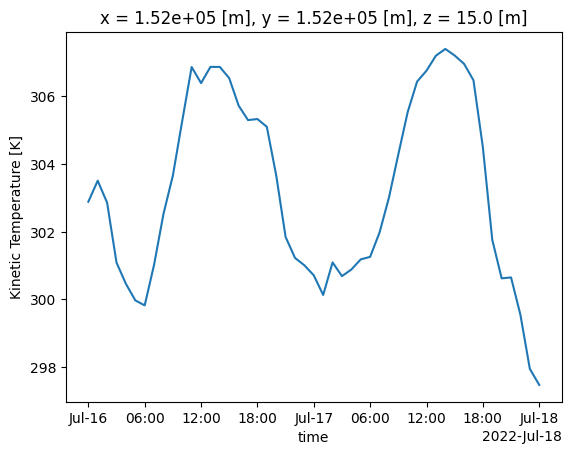

In [8]:
#or to plot the time series of the temperature in the center of the domain
ds['Temp'][:,0,75,75].plot()

In the plot above you can see the diurnal cycle of the temperature that picks around 12pm and get to its lowest at 6am.

lets now plot the terrain data on a geographic coordinate system. The plot above is showing the data on the cartesian grid of the domain simulation.

/opt/imfse/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/imfse/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


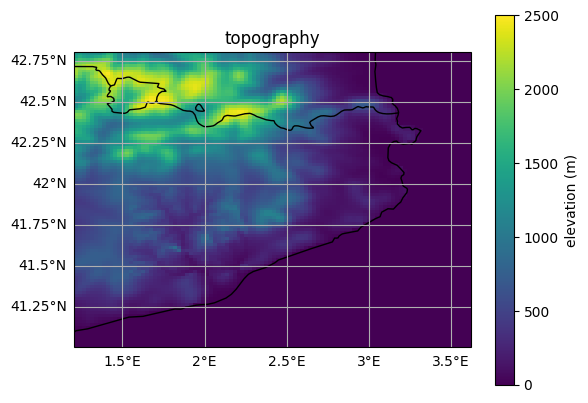

In [9]:
# Plot the data

crs_here = ccrs.PlateCarree() 

fig, ax = plt.subplots(subplot_kw={'projection': crs_here})

# Add borders, coastlines and gridlines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
gl = ax.gridlines(draw_labels=True)

# Disable labels on the right and top sides
gl.right_labels = False
gl.top_labels = False

# Plot data using pcolormesh
colm = ax.pcolormesh(ds.lon, ds.lat, ds.topography, cmap='viridis', shading='auto', transform=crs_here)

# Add a colorbar
plt.colorbar(colm, ax=ax, orientation='vertical', label='elevation (m)')

# Set title
plt.title('topography')

plt.show()

lest now project this map on a UTM projection coordinate system [epsg:25831](https://epsg.io/25831).

In [10]:
# Define the source and target CRS
source_crs = "EPSG:4326"  # WGS84 - Latitude/Longitude
target_crs = "EPSG:25831" # ETRS89 / UTM zone 31N

# Create a Transformer object
transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)

# Transform the coordinates
easting, northing = transformer.transform(ds.lon, ds.lat)

/opt/imfse/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1768: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


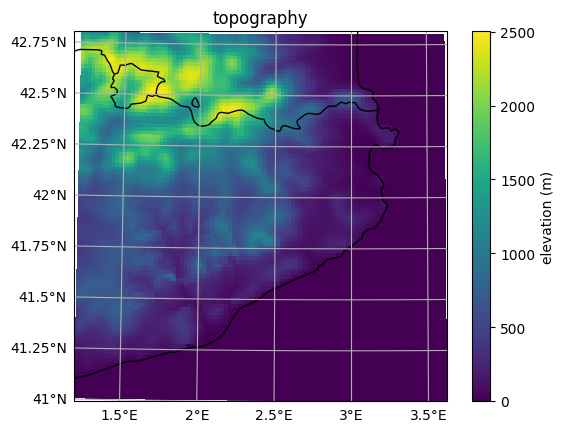

In [11]:
# Plot the data

crs_here = ccrs.epsg(25831) 

fig, ax = plt.subplots(subplot_kw={'projection': crs_here})

# Add borders, coastlines and gridlines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
gl = ax.gridlines(draw_labels=True)

# Disable labels on the right and top sides
gl.right_labels = False
gl.top_labels = False

# Plot data using pcolormesh
colm = ax.pcolormesh(easting, northing, ds.topography, cmap='viridis', shading='auto', transform=crs_here)

# Add a colorbar
plt.colorbar(colm, ax=ax, orientation='vertical', label='elevation (m)')

# Set title
plt.title('topography')

plt.show()

See that now we have here again an aspect ration of 1 (the image is a square). In the Platecarree projection above, the aspect ration is different from 1 as 1 degree of longitude is only equivalent in distance to 1 degree of latitude at the equator. As you can see below meridian are getting closer at higher/lower latitude in the north/south pole.

/opt/imfse/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


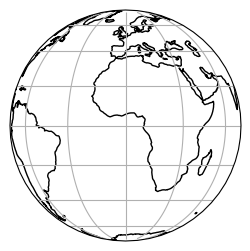

In [12]:
plt.figure(figsize=(3, 3))
ax = plt.axes(projection=ccrs.Orthographic())
ax.coastlines(resolution='110m')
ax.gridlines()